In [11]:
!pip install numpy matplotlib nibabel tensorflow


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model


In [13]:
data_dir = "C:/Users/USER/Downloads/Task01_BrainTumour"
images_tr_dir = os.path.join(data_dir, "imagesTr")
labels_tr_dir = os.path.join(data_dir, "labelsTr")


In [14]:
# List the files in the images and labels directories
image_files = os.listdir(images_tr_dir)
label_files = os.listdir(labels_tr_dir)

# Print the number of files in each directory
print("Number of image files:", len(image_files))
print("Number of label files:", len(label_files))


Number of image files: 495
Number of label files: 485


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


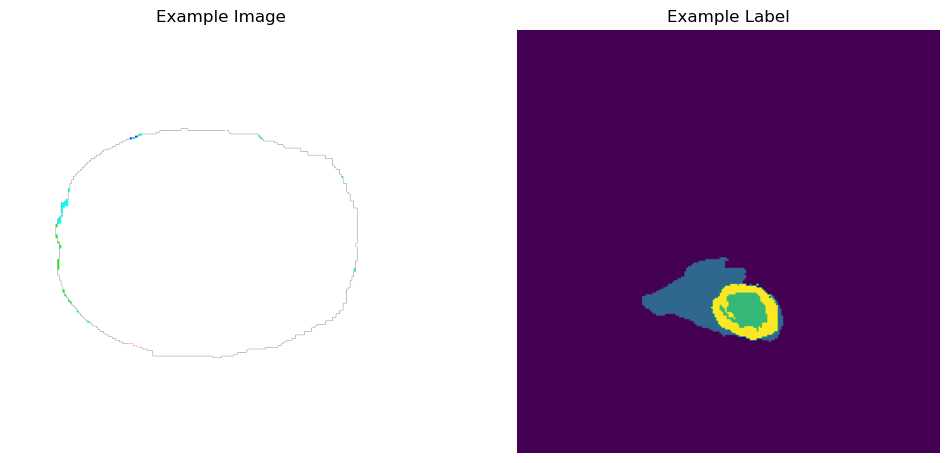

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

# Define the data directory and subdirectories
data_dir = "C:/Users/USER/Downloads/Task01_BrainTumour"
images_tr_dir = os.path.join(data_dir, "imagesTr")
labels_tr_dir = os.path.join(data_dir, "labelsTr")

# List the files in the images and labels directories, filtering out hidden files
image_files = [file for file in os.listdir(images_tr_dir) if not file.startswith('._')]
label_files = [file for file in os.listdir(labels_tr_dir) if not file.startswith('._')]

# Select one example image and its corresponding label
example_image_file = os.path.join(images_tr_dir, image_files[0])
example_label_file = os.path.join(labels_tr_dir, label_files[0])

# Load the example image and label using nibabel
example_image = nib.load(example_image_file).get_fdata()
example_label = nib.load(example_label_file).get_fdata()

# Visualize the example image and label
plt.figure(figsize=(12, 6))

# Plot the image
plt.subplot(1, 2, 1)
plt.imshow(example_image[:, :, example_image.shape[2] // 2], cmap='gray')
plt.title('Example Image')
plt.axis('off')

# Plot the label
plt.subplot(1, 2, 2)
plt.imshow(example_label[:, :, example_label.shape[2] // 2], cmap='viridis')
plt.title('Example Label')
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


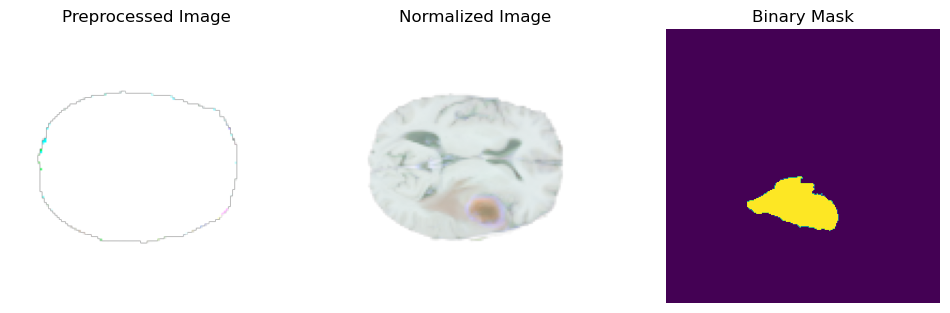

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize

# Define the data directory and subdirectories
data_dir = "C:/Users/USER/Downloads/Task01_BrainTumour"
images_tr_dir = os.path.join(data_dir, "imagesTr")
labels_tr_dir = os.path.join(data_dir, "labelsTr")

# List the files in the images and labels directories, filtering out hidden files
image_files = [file for file in os.listdir(images_tr_dir) if not file.startswith('._')]
label_files = [file for file in os.listdir(labels_tr_dir) if not file.startswith('._')]

# Select one example image and its corresponding label
example_image_file = os.path.join(images_tr_dir, image_files[0])
example_label_file = os.path.join(labels_tr_dir, label_files[0])

# Load the example image and label using nibabel
example_image = nib.load(example_image_file).get_fdata()
example_label = nib.load(example_label_file).get_fdata()

# Define a function for data preprocessing
def preprocess_data(image, label):
    # Resize the image to a common size (e.g., 128x128)
    target_size = (128, 128, image.shape[2])  # Define the target size
    resized_image = resize(image, target_size, anti_aliasing=True)
    
    # Normalize the pixel values to the range [0, 1]
    normalized_image = (resized_image - resized_image.min()) / (resized_image.max() - resized_image.min())
    
    # Convert the label into a binary mask
    binary_mask = (label > 0).astype(int)
    
    return resized_image, normalized_image, binary_mask

# Preprocess the example image and label
resized_image, normalized_image, binary_mask = preprocess_data(example_image, example_label)

# Visualize the preprocessed image and binary mask
plt.figure(figsize=(12, 6))

# Plot the preprocessed image
plt.subplot(1, 3, 1)
plt.imshow(resized_image[:, :, resized_image.shape[2] // 2], cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')

# Plot the normalized image (optional)
plt.subplot(1, 3, 2)
plt.imshow(normalized_image[:, :, normalized_image.shape[2] // 2], cmap='gray')
plt.title('Normalized Image')
plt.axis('off')

# Plot the binary mask
plt.subplot(1, 3, 3)
plt.imshow(binary_mask[:, :, binary_mask.shape[2] // 2], cmap='viridis')
plt.title('Binary Mask')
plt.axis('off')

plt.show()


In [21]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_shape=(128, 128, 1)):
    # Input layer
    inputs = Input(input_shape)
    
    # Encoder (Contracting Path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Decoder (Expanding Path)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    up1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv3)
    up1 = concatenate([up1, conv2], axis=3)
    
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up2 = concatenate([up2, conv1], axis=3)
    
    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(up2)
    
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the U-Net model
model = unet_model()

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [32]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from sklearn.model_selection import train_test_split

# Define the data directory and subdirectories
#data_dir = "C:/Users/USER/Downloads/Task01_BrainTumour"
#images_tr_dir = os.path.join(data_dir, "imagesTr")
#labels_tr_dir = os.path.join(data_dir, "labelsTr")

# List the files in the images and labels directories, filtering out hidden files
#image_files = [file for file in os.listdir(images_tr_dir) if not file.startswith('._')]
#label_files = [file for file in os.listdir(labels_tr_dir) if not file.startswith('._')]

# Define the directory for validation images and labels
images_val_dir = os.path.join(data_dir, "imagesVal")
labels_val_dir = os.path.join(data_dir, "labelsVal")

# List the files in the validation images and labels directories, filtering out hidden files
val_image_files = [file for file in os.listdir(images_val_dir) if not file.startswith('._')]
val_label_files = [file for file in os.listdir(labels_val_dir) if not file.startswith('._')]

# Define a function for data preprocessing
def preprocess_data(image, label):
    # Resize the image to a smaller size (e.g., 64x64x77)
    target_size = (64, 64, 77)
    resized_image = resize(image, target_size, anti_aliasing=True)
    
    # Normalize the pixel values to the range [0, 1]
    normalized_image = (resized_image - resized_image.min()) / (resized_image.max() - resized_image.min())
    
    # Convert the label into a binary mask
    binary_mask = (label > 0).astype(int)
    
    return resized_image, normalized_image, binary_mask

def image_data_generator(image_files, label_files, batch_size):
    num_samples = len(image_files)
    num_batches = num_samples // batch_size
    
    for i in range(num_batches):
        batch_image_files = image_files[i * batch_size : (i + 1) * batch_size]
        batch_label_files = label_files[i * batch_size : (i + 1) * batch_size]
        
        batch_images = []
        batch_labels = []
        
        for image_file, label_file in zip(batch_image_files, batch_label_files):
            image = nib.load(os.path.join(images_tr_dir, image_file)).get_fdata()
            label = nib.load(os.path.join(labels_tr_dir, label_file)).get_fdata()
            
            # Preprocess the data
            preprocessed_image, _, preprocessed_label = preprocess_data(image, label)
            
            batch_images.append(preprocessed_image)
            batch_labels.append(preprocessed_label)
        
        yield np.array(batch_images), np.array(batch_labels)

# Example usage with reduced batch size
batch_size = 1
train_generator = image_data_generator(image_files, label_files, batch_size)
#val_generator = image_data_generator(val_image_files, val_label_files, batch_size)
val_generator = image_data_generator(val_image_files, val_label_files, batch_size)

# Define batch size for the generator
#batch_size = 16

# Create image data generator instances for training and validation
#train_generator = image_data_generator(image_files, label_files, batch_size)
#val_generator = image_data_generator(image_files, label_files, batch_size)

# Example usage of the generators (iterate over batches)
for batch_images, batch_labels in train_generator:
    # Use the batch images and labels for training
    pass  # Replace this with your training code

for batch_images, batch_labels in val_generator:
    # Use the batch images and labels for validation
    pass  # Replace this with your validation code

# Optionally, split the data into training and validation sets (using train_test_split)
# X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/USER/Downloads/Task01_BrainTumour\\imagesVal'